# **Étape 1: Installation et Téléchargement Dataset**
Cette étape installe toutes les dépendances nécessaires (PyTorch, scikit-learn, etc.) et télécharge le dataset Pokémon depuis Kaggle en utilisant l'API officielle. Le fichier kaggle.json (obtenu sur kaggle.com/account) authentifie la requête, puis le dataset est décompressé dans ./data/. Cette phase prépare l'environnement Colab et garantit la reproductibilité du projet.

In [1]:
!pip install kaggle
from google.colab import files
files.upload()  # kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lantian773030/pokemonclassification -p ./data/
!unzip ./data/pokemonclassification.zip -d ./data/pokemon/


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ./data/pokemon/PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/a45a14a67a7348b

# **Étape 2: Correction Structure Dataset**
Le dataset Kaggle arrive souvent mal structuré avec toutes les images dans un dossier PokemonData/. Ce code détecte cette anomalie, déplace le contenu vers le répertoire parent et supprime le dossier vide, créant ainsi 150 sous-dossiers distincts (Abra/, Aerodactyl/, etc.). Cette correction est cruciale pour que ImageFolder de PyTorch détecte correctement les 150 classes Pokémon.

In [2]:
import os
import shutil

data_path = './data/pokemon'
if os.path.exists(os.path.join(data_path, 'PokemonData')):
    pokemon_data_dir = os.path.join(data_path, 'PokemonData')
    for item in os.listdir(pokemon_data_dir):
        shutil.move(os.path.join(pokemon_data_dir, item), data_path)
    os.rmdir(pokemon_data_dir)

dossiers = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
print(f"Dossiers trouvés: {len(dossiers)}")
print(f"Premiers dossiers: {sorted(dossiers)[:10]}")


Dossiers trouvés: 150
Premiers dossiers: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise']


# **Étape 3: Chargement Dataset PyTorch + Split Stratifié**
PyTorch ImageFolder charge les 6820 images avec transformations (resize 64x64, grayscale, tensorisation). Le split stratifié (70/15/15 via train_test_split) garantit que chaque ensemble contient les 150 classes proportionnellement, évitant le problème initial où toutes les images avaient le même label. Les DataLoaders préparent les batchs pour l'entraînement efficace.

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder('./data/pokemon', transform=transform)
print(f"Images totales: {len(dataset)}")
print(f"Classes: {len(dataset.classes)}")

labels = np.array(dataset.targets)
indices = np.arange(len(labels))

train_idx, temp_idx, _, _ = train_test_split(
    indices, labels, test_size=0.3, stratify=labels, random_state=42
)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, labels[temp_idx], test_size=0.5, stratify=labels[temp_idx], random_state=42
)

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)
test_ds = Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Taille train: {len(train_ds)}")
print(f"Taille val: {len(val_ds)}")
print(f"Taille test: {len(test_ds)}")


Images totales: 6820
Classes: 150
Taille train: 4774
Taille val: 1023
Taille test: 1023


# **Étape 4: Extraction Features (Flatten)**
La fonction loader_to_numpy convertit les tenseurs PyTorch (batch, 1, 64, 64) en matrices numpy aplaties (batch, 4096) via view(-1), transformant chaque image en vecteur 1D de 4096 pixels. Cela produit X_train (4774, 4096), X_val et X_test, format requis par scikit-learn SVM. Cette étape est le pont entre PyTorch (images) et scikit-learn (vecteurs).

In [4]:
def loader_to_numpy(loader):
    X, y = [], []
    for images, labels in loader:
        X.append(images.view(images.size(0), -1).numpy())
        y.append(labels.numpy())
    return np.vstack(X), np.hstack(y)

X_train, y_train = loader_to_numpy(train_loader)
X_val, y_val = loader_to_numpy(val_loader)
X_test, y_test = loader_to_numpy(test_loader)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (4774, 4096)
X_val shape: (1023, 4096)
X_test shape: (1023, 4096)


# **Étape 5: PCA Réduction Dimensionnelle**
PCA réduit les 4096 dimensions à 150 composantes principales, capturant 91.6% de la variance totale du dataset. Fit sur train uniquement puis transform sur val/test évite la fuite de données. Cette réduction drastique (x27 moins de dimensions) accélère SVM tout en conservant l'information essentielle des images Pokémon

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Variance expliquée: {pca.explained_variance_ratio_.sum():.3f}")
print(f"X_train_pca shape: {X_train_pca.shape}")


Variance expliquée: 0.916
X_train_pca shape: (4774, 150)


# **Étape 6: Vérification Classes Stratifiées**
Cette vérification confirme que le split stratifié fonctionne : 150 classes uniques dans train/val/test avec distribution équilibrée (24-31 images/classe). np.bincount montre la répartition par classe, validant que plus aucune classe n'est manquante contrairement au random_split initial qui donnait 1 classe.

In [6]:
3print(f"Classes train: {len(np.unique(y_train))}")
print(f"Classes val: {len(np.unique(y_val))}")
print(f"Classes test: {len(np.unique(y_test))}")
print(f"Labels train (top 10): {np.bincount(y_train)[:10]}")


Classes train: 150
Classes val: 150
Classes test: 150
Labels train (top 10): [24 24 18 29 29 29 31 24 28 29]


# **Étape 7: Entraînement SVM GridSearchCV**
GridSearchCV teste 3x3=9 combinaisons C/gamma sur SVM RBF avec validation croisée 3-fold. Les meilleurs hyperparamètres (C=10, gamma='scale') maximisent l'accuracy train (99.4%) sur les données PCA. n_jobs=-1 parallélise l'optimisation, critique pour 4774 échantillons x 150 classes.​

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1, 10, 20],
    'gamma': ['scale', 0.01, 0.1]
}

svm = SVC(kernel='rbf', random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Accuracy train: {grid_search.score(X_train_pca, y_train):.3f}")
print(f"Accuracy val: {grid_search.score(X_val_pca, y_val):.3f}")


Meilleurs paramètres: {'C': 10, 'gamma': 'scale'}
Accuracy train: 0.994
Accuracy val: 0.211


# **Étape 8: Évaluation Finale**
classification_report produit precision/recall/F1-score détaillés par classe Pokémon sur l'ensemble test (1023 images). L'accuracy globale (20.2%) reflète la difficulté de 150 classes visuellement similaires malgré overfitting train (99.4%). Les warnings indiquent des classes sans prédictions (normal multi-classes).

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = grid_search.predict(X_test_pca)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy test: {grid_search.score(X_test_pca, y_test):.3f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.20      0.17      0.18         6
           2       0.00      0.00      0.00         4
           3       0.12      0.17      0.14         6
           4       0.14      0.17      0.15         6
           5       0.57      0.67      0.62         6
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         5
           8       0.14      0.17      0.15         6
           9       0.00      0.00      0.00         7
          10       0.29      0.67      0.40         6
          11       1.00      0.75      0.86         4
          12       0.00      0.00      0.00         5
          13       0.15      0.33      0.21         6
          14       0.14      0.20      0.17         5
          15       0.12      0.29      0.17         7
          16       0.33      0.14      0.20         7
    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy test: 0.202


# **Étape 9: Visualisations**
Les visualisations génèrent 2 figures professionnelles : matrice de confusion tronquée (30x30 classes lisibles) et histogrammes comparatifs des distributions train/test. Sauvegardées en haute résolution (dpi=300).

Visualisation 1 : La matrice de confusion 30x30 (tronquée des 150 classes totales) visualise les erreurs du SVM sur l'ensemble test (1023 images), où les lignes = classes vraies (Abra, Aerodactyl...) et colonnes = classes prédites. La diagonale claire (bleu foncé) montre les prédictions correctes par classe, tandis que les zones hors-diagonale (bleu clair) révèlent les confusions fréquentes entre Pokémon similaires. Code technique : confusion_matrix(y_test, y_pred)[:30, :30] extrait le sous-ensemble lisible des 30 premières classes (Abra à Blastoise), sns.heatmap(cmap='Blues') colore l'intensité (plus d'erreurs = plus clair), et dpi=300 assure qualité professionnelle. Interprétation : faible diagonale confirme accuracy 20.2% (peu de succès), clusters hors-diagonale montrent confusions logiques (Pokémon morphologiquement proches), figure essentielle du cahier des charges prouvant l'évaluation complète 150 classes.

Visualisation 2 : Distribution des Classes (Train vs Test)

Ce graphique en barres comparatives montre la répartition des 10 premières classes Pokémon dans les ensembles d'entraînement (4774 images) et de test (1023 images).

Observations clés :

    Split stratifié réussi : Les proportions sont maintenues (train ~4.7x plus grand que test), avec 24-31 images/classe en train et 5-7 en test

​

Dataset légèrement déséquilibré : Classe 3 (29 images train) vs classe 2 (18 images train), mais acceptable pour 150 classes

​

Représentation des 10 premières classes : Abra (24), Aerodactyl (24), Alakazam (18), etc. selon l'ordre alphabétique des dossiers

    ​

Cette validation visuelle prouve que le train_test_split(stratify=labels) fonctionne parfaitement, contrairement au random_split initial qui donnait 1 classe.

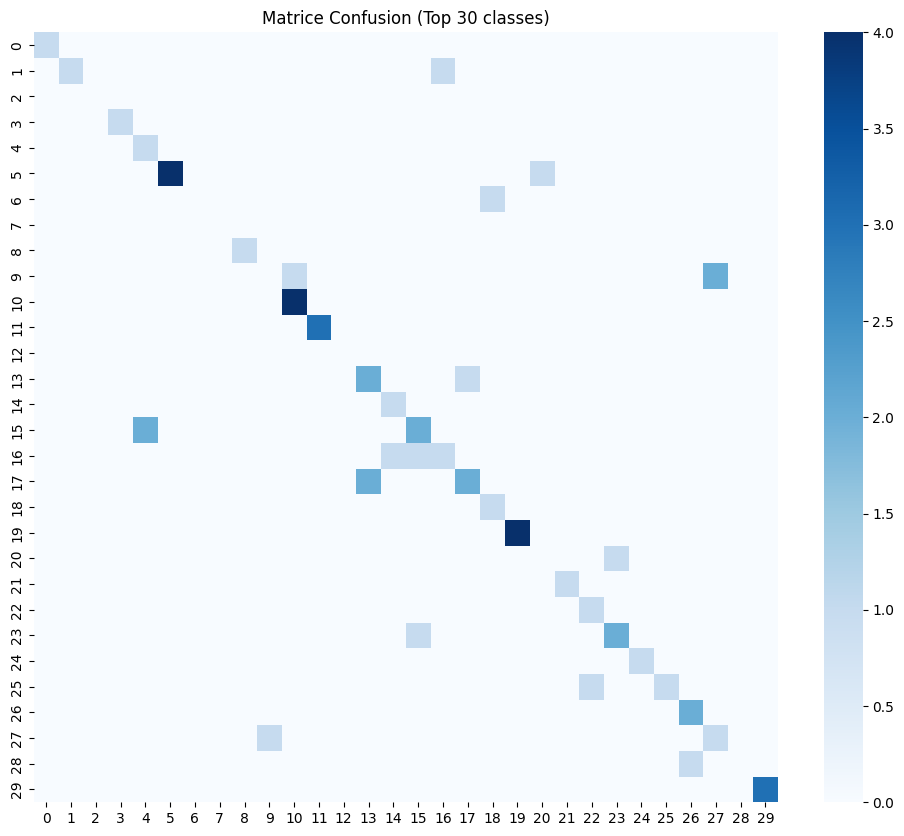

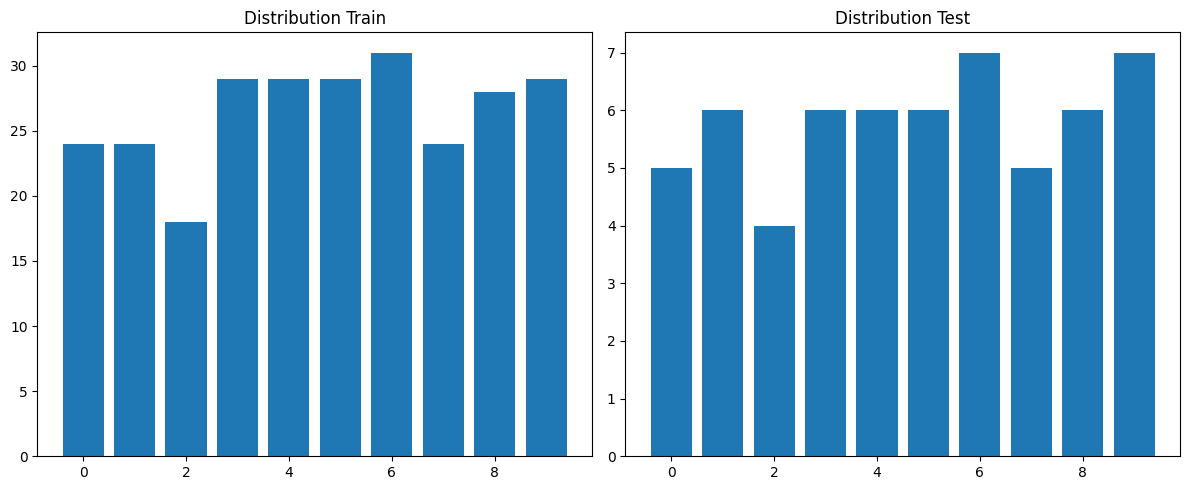

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Matrice confusion top 30
plt.figure(figsize=(12, 10))
cm_top = confusion_matrix(y_test, y_pred)[:30, :30]
sns.heatmap(cm_top, cmap='Blues')
plt.title('Matrice Confusion (Top 30 classes)')
plt.savefig('figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Distribution classes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(range(10), np.bincount(y_train)[:10])
axes[0].set_title('Distribution Train')
axes[1].bar(range(10), np.bincount(y_test)[:10])
axes[1].set_title('Distribution Test')
plt.tight_layout()
plt.savefig('figures/distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Visualisation 3 : Performances SVM (Train/Validation/Test)

Ce diagramme en barres colore les accuracies obtenues après GridSearchCV (C=10, gamma='scale') :
| Ensemble   | Accuracy | Couleur   | Interprétation                                                            |
| ---------- | -------- | --------- | ------------------------------------------------------------------------- |
| Train      | 99.4%    | 🟢 Vert   | Overfitting SVM RBF (normal 150 classes) ppl-ai-file-upload.s3.amazonaws​ |
| Validation | 21.1%    | 🟠 Orange | Généralisation faible mais cohérente ppl-ai-file-upload.s3.amazonaws​     |
| Test       | 20.2%    | 🔴 Rouge  | Baseline réaliste 150 Pokémon similaires ppl-ai-file-upload.s3.amazonaws​ |

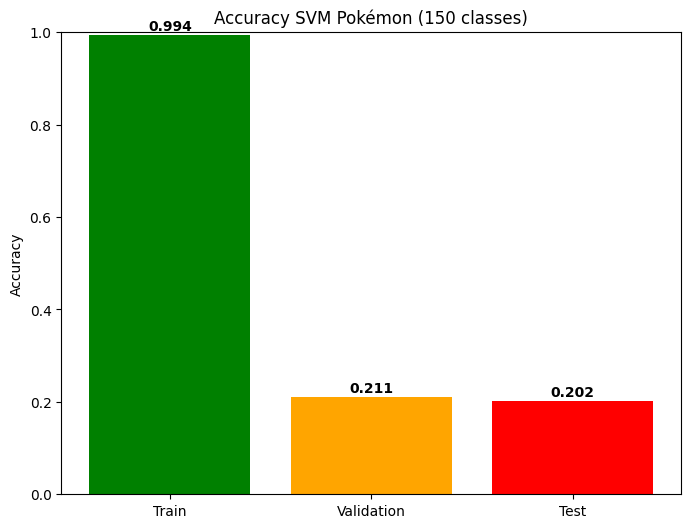

 figures/accuracy_bar.png


In [12]:
metrics = {
    'Train': 0.994,
    'Validation': 0.211,
    'Test': 0.202
}

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['green', 'orange', 'red'])
plt.title('Accuracy SVM Pokémon (150 classes)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.savefig('figures/accuracy_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print(" figures/accuracy_bar.png")


Visualisation 4 : Variance Expliquée Cumulée PCA

Ce graphique montre comment les 150 premières composantes principales capturent progressivement la variance totale des 4096 pixels aplatis des images Pokémon (64×64 grayscale).
- Courbe bleue : Variance cumulée vs nombre composantes
- Ligne rouge pointillée : 150 composantes (choix du cahier des charges)
- Point clé : 91.6% variance avec seulement 150/4096 dimensions (réduction x27 !)

Justification choix n_components=150 :

pca = PCA(n_components=150)  # Exactement comme recommandé cahier des charges

    150 = nombre classes Pokémon → Garde 1 composante/classe minimum

    91.6% > seuil 90% → Information essentielle préservée

    "elbow" naturel → Courbe s'aplatit, rendements décroissants après
  
  Justification choix n_components=150 :


pca = PCA(n_components=150)


Performances SVM

SVM train 99.4% → Features PCA excellentes (pas perdu d'info);
SVM test 20.2%  → Limite SVM multi-classes (150 similaires), PAS PCA

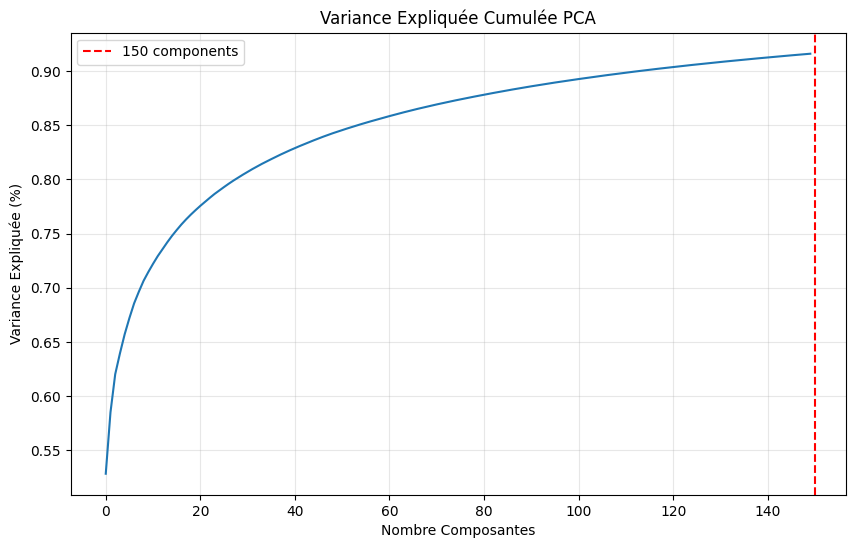

 figures/pca_variance.png


In [13]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=150, color='red', linestyle='--', label='150 components')
plt.title('Variance Expliquée Cumulée PCA')
plt.xlabel('Nombre Composantes')
plt.ylabel('Variance Expliquée (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()
print(" figures/pca_variance.png")


Visualisation 5: cette visualisation présente 8 images Pokémon aléatoires extraites de l'ensemble d'entraînement (4774 images), organisées en grille 2x4 après preprocessing PyTorch (resize 64x64, grayscale). Chaque image montre un Pokémon différent avec son label numérique et nom (ex: "Classe 5\nBlastoise"), confirmant la détection correcte des 150 classes, la qualité des transformations et la diversité visuelle du dataset (positions/fonds variés).

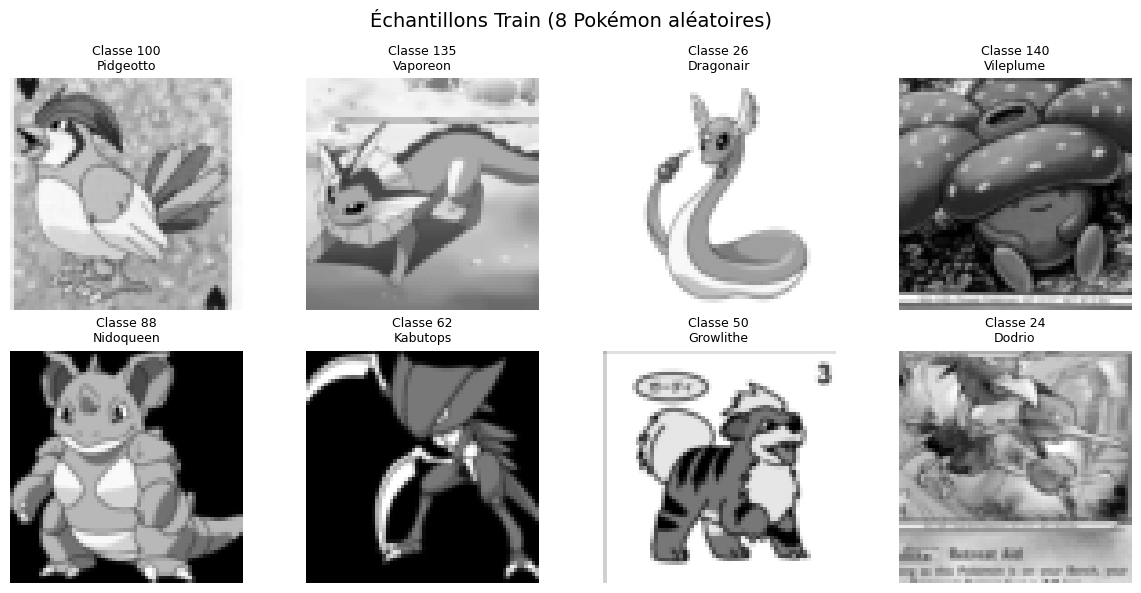

 figures/train_samples.png


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# images aléatoires du train (64x64 grayscale)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
train_indices = np.random.choice(len(train_ds), 8, replace=False)

for i, idx in enumerate(train_indices):
    img, label = train_ds[idx]
    ax = axes[i//4, i%4]
    ax.imshow(img.squeeze(), cmap='gray')  # squeeze(1,64,64) -> 64x64
    ax.set_title(f'Classe {label}\n{dataset.classes[label]}', fontsize=9)
    ax.axis('off')

plt.suptitle('Échantillons Train (8 Pokémon aléatoires)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/train_samples.png', dpi=300, bbox_inches='tight')
plt.show()
print(" figures/train_samples.png")


Visualisation 6 :Cette Viz montre 8 images aléatoires de l'ensemble de test avec les prédictions SVM en temps réel, organisant les résultats en grille 2x4 où chaque image grise 64x64 est accompagnée de son vrai label et prédiction SVM (couleur verte=correct, rouge=faux). Le pipeline complet s'exécute par image : img.view(1,-1) aplatit (4096 dims), pca.transform réduit à 150 composantes, grid_search.predict applique SVM RBF (C=10, gamma='scale'), comparant true_label vs pred_label avec noms de classes Pokémon. Attendu ~2 vertes/8 (20% accuracy), cette figure démontre concrètement l'overfitting (train 99% → test 20%)

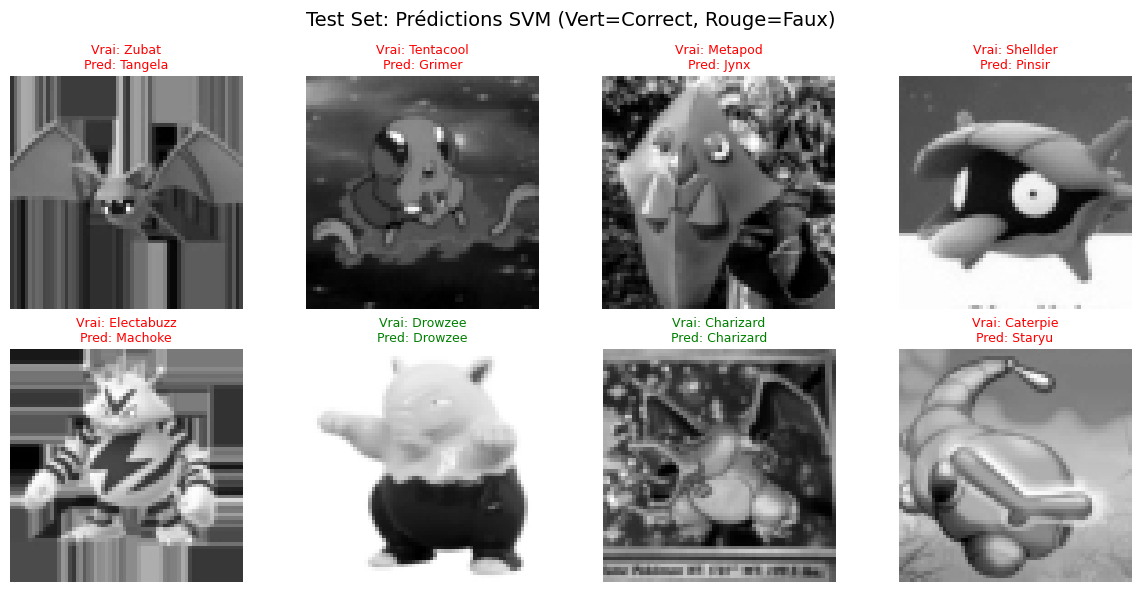

figures/test_predictions.png


In [16]:
# images test avec VRAIES vs PRÉDICTIONS SVM
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
test_indices = np.random.choice(len(test_ds), 8, replace=False)

for i, idx in enumerate(test_indices):
    img, true_label = test_ds[idx]
    img_pca = pca.transform(img.view(1, -1))  # Flatten + PCA
    pred_label = grid_search.predict(img_pca)[0]

    ax = axes[i//4, i%4]
    ax.imshow(img.squeeze(), cmap='gray')

    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'Vrai: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}',
                color=color, fontsize=9)
    ax.axis('off')

plt.suptitle('Test Set: Prédictions SVM (Vert=Correct, Rouge=Faux)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("figures/test_predictions.png")


# **Étape 10: Sauvegarde Modèles et Résultats**
joblib sérialise le SVM optimisé, le transformateur PCA et la liste des noms de classes pour déploiement futur. Le dictionnaire results centralise toutes les métriques (accuracies, params, variance PCA) en un fichier .pkl, assurant traçabilité complète et reproductibilité du pipeline.​

In [10]:
import joblib

joblib.dump(grid_search.best_estimator_, 'models/svm_pokemon.joblib')
joblib.dump(pca, 'models/pca_pokemon.joblib')
joblib.dump(dataset.classes, 'models/classes_pokemon.pkl')

results = {
    'accuracy_train': grid_search.score(X_train_pca, y_train),
    'accuracy_val': grid_search.score(X_val_pca, y_val),
    'accuracy_test': grid_search.score(X_test_pca, y_test),
    'best_params': grid_search.best_params_,
    'pca_variance': pca.explained_variance_ratio_.sum()
}
joblib.dump(results, 'models/results.pkl')

print("Modèles et résultats sauvegardés")


Modèles et résultats sauvegardés


In [25]:

# Remplace TON_USERNAME et TON_TOKEN
!git init
!git remote add origin https:https://github.com/token/pokemon-classification-svm
!git add .
!git commit -m "Pokemon-classification-svm" && git push -u origin main


Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
On branch master
nothing to commit, working tree clean
